# STAT DESC ET ETUDES DE CAS 
## PREMIERES TENDANCES AVEC LES STATS DESC


Le but de cette partie est d'évaluer les premières tendances que l'on pourrait remarquer. Notre objectif est de voir si on remarque facilement des spécifités géographiques dans la répartition des maladies

On importe tous les modules nécéssaires :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

On importe nos base de travail issue de sources diverses mais généralement insee + data gouv (à modifier)

In [3]:
#La base de données effectifs, notre base de travai principale qui nous renseigne sur les pathologies, issue de datagouv 
eff = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

On réalise quelques histogrammes pour voir quels sont les tendances qui se dessinent :

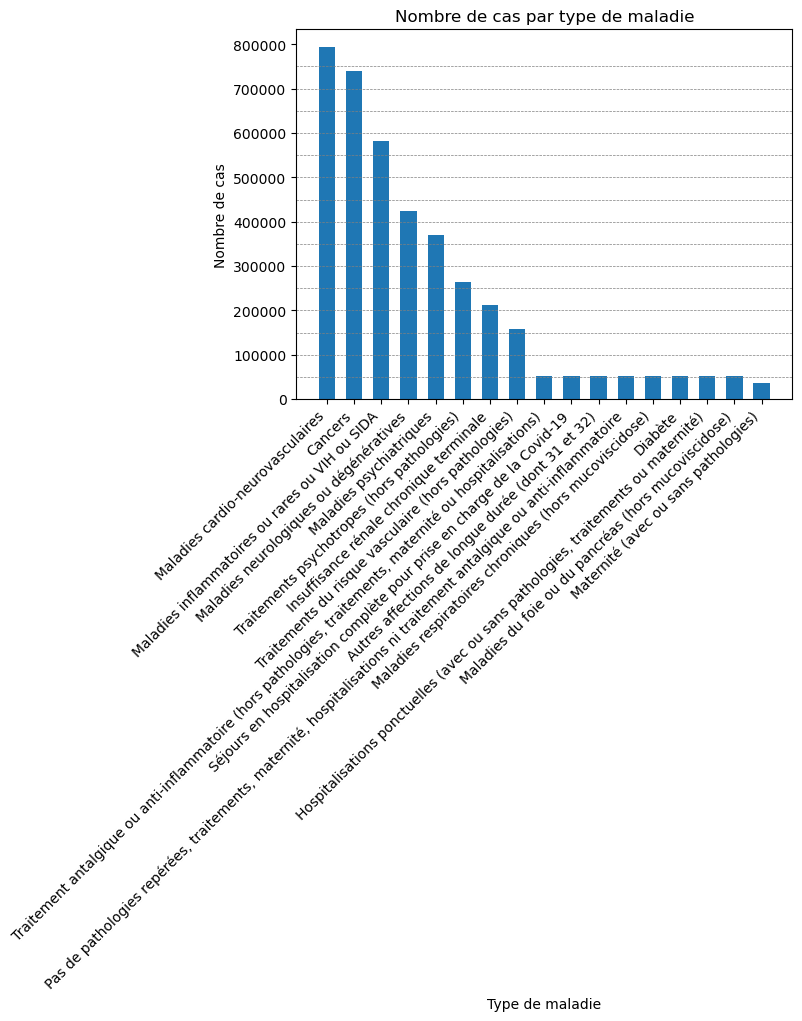

In [4]:
#Diagramme en barres sur le nombre de cas par type de maladie

# Compter le nombre de cas par type de maladie
counts = eff['patho_niv1'].value_counts()

# Créer le diagramme en barres
plt.bar(counts.index, counts.values,  width=0.6)
plt.xlabel('Type de maladie')
plt.ylabel('Nombre de cas')
plt.title('Nombre de cas par type de maladie')

# Ajouter des lignes horizontales en arrière-plan
for y in range(0, max(counts.values) + 1, 50000):  # Ajuster l'espacement des lignes selon vos besoins
    plt.axhline(y, color='gray', linestyle='--', linewidth=0.5)

# Rotation des étiquettes en diagonale
plt.xticks(rotation=45, ha='right')

plt.show()

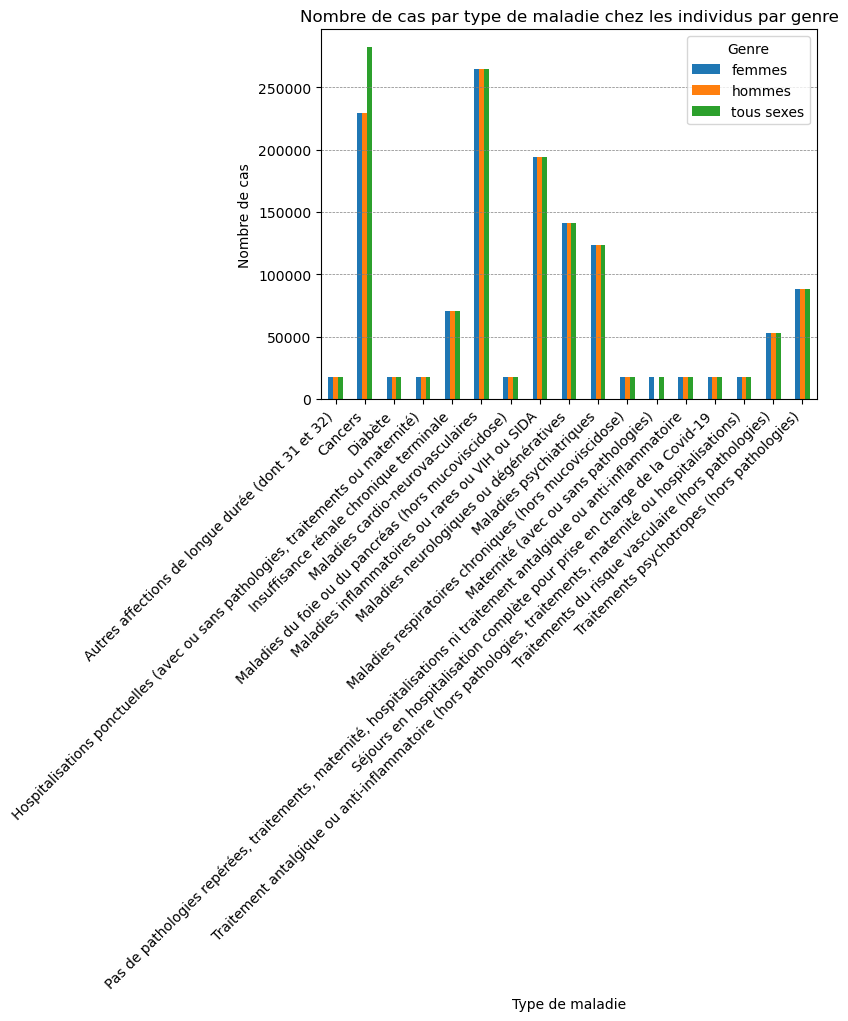

In [5]:
#Diagramme en barre pour le nombre de malades en fonction du sexe
#On ne voit pas de différence à cause de l'échelle
#sélectionner qq colonnes et "zoomer"
#en fait les résultats affichés me paraissent louches

# Compter le nombre de cas par type de maladie et par genre
counts = eff.groupby(['patho_niv1', 'libelle_sexe']).size().unstack(fill_value=0)

# Créer le diagramme en barres
ax = counts.plot(kind='bar', stacked=False)

# Ajouter des lignes horizontales dans l'arrière-plan
for y in range(50, max(counts.max())+1, 50000):
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# Orienter le texte sur l'axe des x 
plt.xticks(rotation=45, ha='right')


plt.xlabel('Type de maladie')
plt.ylabel('Nombre de cas')
plt.title('Nombre de cas par type de maladie chez les individus par genre')
plt.legend(title='Genre', loc='upper right')

plt.show()
